<a id="top"></a>

## Restaurant Review AspectCategory (5 classes) and Polarity Classification (4 classes)
### Using Logistic Regression, DAN, CNN

In [ ]:
import pandas as pd
import random
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install -U spacy
!python -m spacy download en
import spacy
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

<br>
<hr style="border: 4px solid #B7C9F2;" />
<hr style="border: 2px solid #FB88B4;" />

---

<a id="top"></a>

# Download Data

In [ ]:
!gdown --id 10fHsgc9E1n_JgaV-mmS818cF9QL_5Wwg # train data from contest1 file
!gdown --id 1gbC4rWAwyBL9ZDHnQRqPbKOhPBPAlh5z  # evaluate.py

In [ ]:
test_data = pd.read_csv('contest1_test.csv')
data = pd.read_csv('contest1_train.csv')
data

,id,text,aspectCategory,polarity
0,3121,But the staff was so horrible to us.,service,negative
1,2777,"To be completely fair, the only redeeming fact...",food,positive
2,2777,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative
3,1634,"The food is uniformly exceptional, with a very...",food,positive
4,2534,Where Gabriela personaly greets you and recomm...,service,positive
...,...,...,...,...
3151,2853,I would highly recommend this place to everyon...,anecdotes/miscellaneous,positive
3152,1163,The service is fantastic.,service,positive
3153,216,I recommend that you try this hidden spot whic...,anecdotes/miscellaneous,positive
3154,1109,The garlic mashed potatoes are hands down the ...,food,positive


In [ ]:
data.polarity.value_counts()

positive    1876
negative     715
neutral      398
conflict     167
Name: polarity, dtype: int64

In [ ]:
data.aspectCategory.value_counts()

food                       1051
anecdotes/miscellaneous     956
service                     506
ambience                    368
price                       275
Name: aspectCategory, dtype: int64

<br>
<hr style="border: 4px solid #B7C9F2;" />
<hr style="border: 2px solid #FB88B4;" />

---

<a id="top"></a>

## Tokenize Data

In [ ]:
import re
# Load spacy model
from sklearn.feature_extraction import DictVectorizer
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
nltk.download('stopwords')
def tokenize(text):
  tokens = nltk.word_tokenize(text)
  patt = re.compile('[a-zA-Z0-9]+')
  new_tokens = [x.lower() for x in tokens if patt.match(x) and not x in all_stopwords]
  return '|'.join(new_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data['tokens'] = data.text.apply(tokenize)
clean_data = data[['id', 'tokens', 'aspectCategory', 'polarity']]
#clean_data['tokens'].apply(lambda x: x.split('|'))

In [ ]:
test_data['tokens'] = test_data.text.apply(tokenize)
clean_test_data = test_data[['id', 'tokens']]
clean_test_data

,id,tokens
0,899,food|service|okay
1,1349,great|romantic|evening|fun|evening|friends
2,934,the|lamb|meat|under-cooked|extrmely|chewy
3,2199,the|best|pad|thai
4,188,over|time|food|quality|decreased|substantially...
...,...,...
456,1063,but|highly|forgivable
457,777,from|appetizers|ate|dim|sum|variety|foods|impo...
458,875,when|arrived|6:00|pm|restaurant|practically
459,671,each|table|pot|boiling|water|sunken|surface|pl...


In [ ]:
train, dev = train_test_split(clean_data, train_size=0.8, random_state=160)

price = train['aspectCategory'] == 'price'
ambience = train['aspectCategory'] == 'ambience'
service = train['aspectCategory'] == 'service'

df_try_price = train[price]
df_try_ambience = train[ambience]
df_try_service = train[service]

train = train.append([df_try_price] * 6)
train = train.append([df_try_ambience] * 2)
train = train.append([df_try_service] * 2)
train

,id,tokens,aspectCategory,polarity
0,3121,but|staff|horrible,service,negative
1,2777,to|completely|fair|redeeming|factor|food|avera...,food,positive
2,2777,to|completely|fair|redeeming|factor|food|avera...,anecdotes/miscellaneous,negative
3,1634,the|food|uniformly|exceptional|capable|kitchen...,food,positive
4,2534,where|gabriela|personaly|greets|recommends|eat,service,positive
...,...,...,...,...
2825,1931,truly|mark|attentive|waiter,service,positive
2827,181,the|food|good|like|wait,service,negative
2829,2455,the|staff|kind|trained|fast|prompt|jump|bar|fi...,service,positive
2833,1465,service|better|possibly|large|group|house|cord...,service,conflict


In [ ]:
train.aspectCategory.value_counts()

price                      1694
service                    1359
ambience                   1005
food                        959
anecdotes/miscellaneous     851
Name: aspectCategory, dtype: int64

### dev to csv

In [ ]:
dev.to_csv('dev.csv', index=None)

<br>
<hr style="border: 4px solid #B7C9F2;" />
<hr style="border: 2px solid #FB88B4;" />

---

<a id="top"></a>

# 1) Logistic Regression

<hr style="border: 2px solid #F1EF99;" />

---


## AspectCategory

In [ ]:
# Feature engineering
def featurize(text):
    return {x:1 for x in text.split('|')}

vectorizer = DictVectorizer(sparse=True)
train_features = train['tokens'].apply(featurize)
feature_vectors = vectorizer.fit_transform(train_features)

# Train model
lr_text_classifier = LogisticRegression()
lr_text_classifier.fit(feature_vectors, train['aspectCategory'])

# Evaluation
dev_features = dev['tokens'].apply(featurize)
dev_feature_vectors = vectorizer.transform(dev_features)
dev_predictions_aspect = lr_text_classifier.predict(dev_feature_vectors)
print(classification_report(dev_predictions_aspect, dev['aspectCategory']))


                         precision    recall  f1-score   support

               ambience       0.64      0.60      0.62        35
anecdotes/miscellaneous       0.74      0.77      0.76       101
                   food       0.62      0.66      0.64        86
                  price       0.39      0.45      0.42        29
                service       0.68      0.55      0.61        65

               accuracy                           0.65       316
              macro avg       0.61      0.61      0.61       316
           weighted avg       0.65      0.65      0.65       316



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
test_features = clean_test_data['tokens'].apply(featurize)
test_feature_vectors = vectorizer.transform(test_features)
test_predictions_aspect = lr_text_classifier.predict(test_feature_vectors)

In [ ]:
# create new dataframe
lr_aspect_newdf = pd.DataFrame()

# add columns (เอาผลมารวมกัน)
lr_aspect_newdf['id'] = clean_test_data['id']
lr_aspect_newdf['tokens'] = clean_test_data['tokens']
lr_aspect_newdf['aspectCategory'] = test_predictions_aspect  # prediction of aspect
lr_aspect_newdf.to_csv('lr_aspect_newdf.csv', index=None)

<br>
<hr style="border: 2px solid #F1EF99;" />

---

## Polarity

In [ ]:
train.polarity.value_counts()

positive    3413
negative    1614
neutral     1380
conflict     381
Name: polarity, dtype: int64

In [ ]:
neutral = train['polarity'] == 'neutral'
df_try_neutral = train[neutral]
train = train.append([df_try_neutral] * 2)

In [ ]:
# Feature engineering
def featurize(text):
    return {x:1 for x in text.split('|')} #{x:1 for x in word_tokenize(text)}

vectorizer = DictVectorizer(sparse=True)
train_features = train['tokens'].apply(featurize)
feature_vectors = vectorizer.fit_transform(train_features)

# Train model
lr_text_classifier = LogisticRegression()
lr_text_classifier.fit(feature_vectors, train['polarity'])

# Evaluation
dev_features = dev['tokens'].apply(featurize)
dev_feature_vectors = vectorizer.transform(dev_features)
dev_predictions_polar = lr_text_classifier.predict(dev_feature_vectors)
print (classification_report(dev_predictions_polar, dev['polarity']))

              precision    recall  f1-score   support

    conflict       0.00      0.00      0.00         0
    negative       0.49      0.44      0.46        75
     neutral       0.31      0.52      0.39        29
    positive       0.85      0.77      0.81       212

    accuracy                           0.67       316
   macro avg       0.41      0.43      0.42       316
weighted avg       0.72      0.67      0.69       316



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samp

<br>
<hr style="border: 2px solid #F1EF99;" />

---

## Test Set

In [ ]:
# create new dataframe
newdf = pd.DataFrame()

# add columns (เอาผลมารวมกัน)
newdf['id'] = dev['id']
newdf['aspectCategory'] = dev_predictions_aspect  # prediction of aspect
newdf['polarity'] = dev_predictions_polar  # prediction of polarity
newdf
# export to csv
newdf.to_csv('lr_pred.csv', index=None)

In [ ]:
!python3 evaluate.py dev.csv lr_pred.csv

=== CLASSIFICATION : ASPECT ===
                class name  precision  recall  F1-score support
0                     food      0.852   0.565     0.680      92
1                    price      0.882   0.455     0.600      33
2                  service      0.814   0.660     0.729      53
3                 ambience      0.800   0.606     0.690      33
4  anecdotes/miscellaneous      0.822   0.790     0.806     105
5                MACRO AVG      0.834   0.615     0.701     316
6                MICRO AVG      0.830   0.649     0.728     316 

=== CLASSIFICATION : SENTIMENT ===
  class name  precision  recall  F1-score support
0   positive      0.780   0.842     0.810     152
1   negative      0.439   0.463     0.450      54
2    neutral      0.577   0.326     0.417      46
3   conflict      0.000   0.000     0.000      10
4  MACRO AVG      0.449   0.408     0.419     262
5  MICRO AVG      0.680   0.641     0.660     262 

=== CLASSIFICATION : OVERALL ===
              precision  recall  F

<br>
<hr style="border: 4px solid #B7C9F2;" />
<hr style="border: 2px solid #FB88B4;" />

---

# 2) Deep Learning Models

In [ ]:
X_train = train['tokens']
X_dev = dev['tokens']


<br>
<hr style="border: 2px solid #F1EF99;" />

---
## Download Word Embedding (GloVe)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-02-21 02:43:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-21 02:43:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-21 02:43:32--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
import os
import pathlib
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), ".keras/datasets/glove.6B.300d.txt"
)

In [ ]:
embeddings_dict = {}
with open('/content/glove.6B.300d.txt', encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_dict[word] = coefs

print("Found %s word vectors." % len(embeddings_dict))

Found 400000 word vectors.


In [ ]:
from keras.preprocessing.text import Tokenizer
vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [ ]:
word_index = tokenizer.word_index
len(word_index)

3564

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_dev_sequences = tokenizer.texts_to_sequences(X_dev)

In [ ]:
X_dev_sequences[101]

[6, 3, 15, 86]

In [ ]:
max_length = 100
padding_type='post'
truncation_type='post'

In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D
from keras.utils import to_categorical, plot_model, pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
def convert_words(sequence, word_index, max_length):
  list_of_list_of_indices = list(sequence)
  return pad_sequences(list_of_list_of_indices, max_length, padding='post', value=len(word_index), truncating='post')

# max length (กำหนดเอง)
train_x = convert_words(X_train_sequences, word_index, max_length)
dev_x = convert_words(X_dev_sequences, word_index, max_length)

In [ ]:
list_of_list_of_indices = X_train_sequences
pad_sequences(list_of_list_of_indices, max_length, padding='post', value=len(word_index), truncating='post')

In [ ]:
dev_x[0]

array([  74,   70, 2683,   17, 3564, 3564, 3564, 3564, 3564, 3564, 3564,
       3564, 3564, 3564, 3564, 3564, 3564, 3564, 3564, 3564], dtype=int32)

In [ ]:
# make weight matrix of word embedding, vocab size + 1 (for padding)
word_index['good']

8


<br>
<hr style="border: 2px solid #F1EF99;" />

---
## Word2Vec Word Embedding

In [ ]:
!git clone https://github.com/tmikolov/word2vec
!cd word2vec && make

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!./word2vec/word2vec

WORD VECTOR estimation toolkit v 0.1c

Options:
Parameters for training:
	-train <file>
		Use text data from <file> to train the model
	-output <file>
		Use <file> to save the resulting word vectors / word clusters
	-size <int>
		Set size of word vectors; default is 100
	-window <int>
		Set max skip length between words; default is 5
	-sample <float>
		Set threshold for occurrence of words. Those that appear with higher frequency in the training data
		will be randomly down-sampled; default is 1e-3, useful range is (0, 1e-5)
	-hs <int>
		Use Hierarchical Softmax; default is 0 (not used)
	-negative <int>
		Number of negative examples; default is 5, common values are 3 - 10 (0 = not used)
	-threads <int>
		Use <int> threads (default 12)
	-iter <int>
		Run more training iterations (default 5)
	-min-count <int>
		This will discard words that appear less than <int> times; default is 5
	-alpha <float>
		Set the starting learning rate; default is 0.025 for skip-gram and 0.05 for CBOW
	-classe

In [ ]:
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D
from keras.utils import to_categorical, plot_model, pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

"\nimport numpy as np\nimport pandas as pd\nfrom numpy.linalg import norm\nfrom sklearn.metrics import classification_report, confusion_matrix\nfrom IPython.display import Image, display_png\nfrom gensim.models import word2vec, KeyedVectors\nfrom keras.models import Sequential\nfrom keras.layers import Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D\n# from keras.utils import to_categorical, plot_model, pad_sequences\nfrom tensorflow.keras.utils import to_categorical, plot_model\nfrom keras.preprocessing.sequence import pad_sequences\nfrom keras.optimizers import RMSprop\nimport matplotlib.pyplot as plt\nplt.style.use('ggplot')\n"

In [ ]:
train['length'] = train['tokens'].apply(lambda x: x.count('|')+1)
dev['length'] = dev['tokens'].apply(lambda x: x.count('|')+1)
train = train[['id', 'tokens', 'length', 'aspectCategory', 'polarity']]
dev = dev[['id', 'tokens', 'length', 'aspectCategory', 'polarity']]
train

,id,tokens,length,aspectCategory,polarity
0,3121,But|staff|horrible,3,service,negative
1,2777,To|completely|fair|redeeming|factor|food|avera...,9,food,positive
2,2777,To|completely|fair|redeeming|factor|food|avera...,9,anecdotes/miscellaneous,negative
3,1634,The|food|uniformly|exceptional|capable|kitchen...,12,food,positive
4,2534,Where|Gabriela|personaly|greets|recommends|eat,6,service,positive
...,...,...,...,...,...
1755,211,Service|food|expect|spending|type|money,6,service,neutral
1933,1886,The|service|ok,3,service,neutral
2065,1734,Service|average,2,service,neutral
2230,1845,However|service|plain|sesame|crusted|Salmon|I,7,service,neutral


In [ ]:
train.length.describe()

count    6407.000000
mean        7.277041
std         3.903481
min         1.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        32.000000
Name: length, dtype: float64

In [ ]:
train.aspectCategory.value_counts()

price                      1701
service                    1353
anecdotes/miscellaneous    1324
food                       1033
ambience                    996
Name: aspectCategory, dtype: int64

In [ ]:
dev.length.describe()

count    316.000000
mean       7.126582
std        3.904794
min        1.000000
25%        4.000000
50%        7.000000
75%        9.000000
max       22.000000
Name: length, dtype: float64

In [ ]:
sentences = train['tokens'].apply(lambda x: x.split('|')).tolist()
from gensim.models import Word2Vec
# Train the Word2Vec model
model = Word2Vec(sentences, size=100, window=5, min_count=1, workers=4, batch_words = 1000)
# Get the word embeddings
w2v_model = model.wv

In [ ]:
# vocabulary size of pre-trained model
vocab_size = len(w2v_model.vocab)
print('vocab size:', vocab_size)

# vector dimension
vector_dim = (len(w2v_model['good']))
print('vector dimension:', vector_dim)

vocab size: 4117
vector dimension: 100


In [ ]:
w2v_model['happy']

array([-0.14242603,  0.08174667,  0.01339445, -0.0336396 ,  0.09633047,
       -0.10733993,  0.02399174,  0.05420462,  0.0268991 ,  0.03311791,
        0.0197526 , -0.11069852,  0.04326565, -0.00369615, -0.07324265,
        0.06095168, -0.02495733, -0.01373175,  0.01161456,  0.03604413,
        0.15097398, -0.0678963 ,  0.00917475, -0.03966276, -0.04849009,
        0.01928027, -0.0752214 ,  0.04198362,  0.07457295,  0.07555541,
        0.00036343,  0.02170697, -0.019302  ,  0.04128383, -0.05149387,
       -0.13866152,  0.09612698,  0.01362117, -0.1458609 , -0.0827679 ,
       -0.0198939 , -0.02244446,  0.124228  ,  0.08499058, -0.00416615,
       -0.01923599, -0.04826722,  0.04689252,  0.00656577, -0.13414145,
       -0.04334337,  0.01905027, -0.0616229 ,  0.07436538, -0.00150412,
       -0.09167643, -0.01263295,  0.03504059, -0.02913037, -0.04797075,
        0.01128621, -0.02698045, -0.02008533,  0.07486624,  0.12074474,
       -0.02268267, -0.06512919, -0.01931636,  0.03441061,  0.06

In [ ]:
w2v_model['good']

array([-0.7927149 ,  0.46092403,  0.07560585, -0.15711243,  0.55846936,
       -0.58470565,  0.1272148 ,  0.3366995 ,  0.12889397,  0.18389782,
        0.10162345, -0.6497651 ,  0.22183435, -0.00743847, -0.3963684 ,
        0.30822653, -0.12529768, -0.05639476,  0.05556531,  0.17339815,
        0.8655698 , -0.3765427 ,  0.02339296, -0.22821286, -0.2668013 ,
        0.07459023, -0.42616957,  0.21492876,  0.42379683,  0.41137147,
       -0.01446245,  0.1084398 , -0.11309155,  0.26934683, -0.2814155 ,
       -0.79521734,  0.55246586,  0.08431306, -0.82136476, -0.4895708 ,
       -0.13470347, -0.1284211 ,  0.6819454 ,  0.45756862, -0.00444587,
       -0.07480697, -0.29122165,  0.24395812,  0.012607  , -0.75866455,
       -0.271286  ,  0.10924201, -0.36411998,  0.40709692, -0.01584184,
       -0.54782647, -0.07799494,  0.18596426, -0.16628681, -0.2730476 ,
        0.07164939, -0.16857463, -0.08618824,  0.4306982 ,  0.6708462 ,
       -0.1585107 , -0.3472383 , -0.09742749,  0.18172699,  0.39

In [ ]:
# make weight matrix of word embedding, vocab size + 2 (for padding and unknown)
embedding_matrix = np.zeros((vocab_size+2, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

word_to_index = {word:i+1 for i, word in enumerate(w2v_model.vocab)}
# word to index dictionary, 0 for padding, UNKNOWN
word_to_index['PADDING'] = 0
word_to_index['<UNK>'] = len(word_to_index)

for i, word in enumerate(w2v_model.vocab):
    embedding_matrix[i+1] = w2v_model[word]

word_to_index['mean']

1348

In [ ]:
len(word_to_index)

4119

In [ ]:
X_train

292                  Lunch came pickels slaw extra charge
1813            Service excellent AC worked thank God hot
3122                              The counter service bad
3134    You pay lot decore food better worse lot Chine...
2867    The service attentive unimposing food far bett...
                              ...                        
1616    They rip-off 8.95 small meat patties steamed b...
2509           I wait summer serve outside gigantic patio
150     The strong scents coming left right negatively...
407                       The food good I onion soup best
678                                   Me girls definitely
Name: tokens, Length: 2524, dtype: object

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 3328 words (290 misses)


In [ ]:
embedding_matrix[0] = np.zeros(embedding_dim)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
word_to_index = {word:i+1 for i, word in enumerate(voc)}

In [ ]:
# make weight matrix of word embedding, vocab size + 2 (for padding and unknown)
embedding_matrix = np.zeros((vocab_size+2, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

word_to_index = {word:i+1 for i, word in enumerate(w2v_model.vocab)}
# word to index dictionary, 0 for padding, UNKNOWN
word_to_index['PADDING'] = 0
word_to_index['<UNK>'] = len(word_to_index)

for i, word in enumerate(w2v_model.vocab):
    embedding_matrix[i+1] = w2v_model[word]

<br>
<hr style="border: 2px solid #9195F6;" />

---
### Convert words into indices and pad + truncate sequences

In [ ]:
def convert_words(df, word_to_index, max_length):
  tokens = df['tokens'].apply(lambda x: x.split('|'))
  list_of_list_of_indices = list(tokens.map(lambda x: [word_to_index.get(word, word_to_index['<UNK>']) for word in x]))
  return pad_sequences(list_of_list_of_indices, max_length, padding='post', value=word_to_index['PADDING'], truncating='post')

# max length (กำหนดเอง)
max_len = 15
train_x = convert_words(train, word_to_index, max_len)
dev_x = convert_words(dev, word_to_index, max_len)
train_x[100]

array([ 33, 377, 378, 379,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [ ]:
train_x[4]

array([24, 25, 26, 27, 28, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

<br>
<hr style="border: 2px solid #9195F6;" />

---
### Mapping labels

In [ ]:
def get_label(df):
  polarity_to_label = {'negative':0, 'neutral':1, 'positive': 2, 'conflict': 3}
  # apply functions & convert to np.array
  label = np.array(df['polarity'].replace(polarity_to_label).tolist())
  df['label'] = label
  return to_categorical(label, num_classes=4)

# label : one-hot vector
train_y = get_label(train)
dev_y = get_label(dev)
print(train_y[100:110])

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# check the shape
print('input train:', train_x.shape)
print('input dev:', dev_x.shape)
print('label train:', train_y.shape)
print('label dev:',dev_y.shape)

input train: (6407, 15)
input dev: (316, 15)
label train: (6407, 4)
label dev: (316, 4)


In [ ]:
def get_label(df):
  aspect_to_label = {'food':0, 'anecdotes/miscellaneous':1, 'service':2, 'ambience':3, 'price':4}
  # apply functions & convert to np.array
  label = np.array(df['aspectCategory'].replace(aspect_to_label).tolist())
  df['label'] = label
  return to_categorical(label, num_classes=5)

# label : one-hot vector
train_y = get_label(train)
dev_y = get_label(dev)
print(train_y[100:110])

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [ ]:
# check the shape
print('input train:', train_x.shape)
print('input dev:', dev_x.shape)
print('label train:', train_y.shape)
print('label dev:',dev_y.shape)

input train: (6407, 15)
input dev: (316, 15)
label train: (6407, 5)
label dev: (316, 5)


## Tensorflow

In [ ]:
!pip install keras.utils
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=e279d038d59c90b8a75992858d44107b1290e283563291ba30bce3fcf82e03b2
  Stored in directory: /root/.cache/pip/wheels/2f/e9/19/d3d310a06735013bf467216222ebb92b1158c5d3ae006bf92a
Successfully built keras.utils


In [ ]:
import numpy as np
import numpy.linalg as LA

In [ ]:
from keras import optimizers
%tensorflow_version

# import numpy as np
import numpy.linalg as LA
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D, BatchNormalization
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#from keras.optimizers import RMSprop

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
num_classes = 5


<hr style="border: 2px solid #F1EF99;" />

---

## Train the model - DAN

In [ ]:
# instantiation
def make_deep_average_net(print_model=True):
    model = Sequential()
    # add embedding layer
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                    input_length=max_len,
                    output_dim=embedding_matrix.shape[1],
                    weights=[embedding_matrix],
                    mask_zero=True,
                    trainable=True))

    # average
    model.add(GlobalAveragePooling1D())

    # add hidden layer
    model.add(Dense(200, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu'))

    # add output layer
    model.add(Dense(4, activation='softmax'))

    # compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    if print_model:
        model.summary()
        plot_model(model, show_shapes=True,to_file='model.png')
        display_png(Image('model.png'))
    return model

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_83 (Embedding)    (None, 15, 100)           411900    
                                                                 
 global_average_pooling1d_12  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_232 (Dense)           (None, 200)               20200     
                                                                 
 dense_233 (Dense)           (None, 128)               25728     
                                                                 
 dropout_86 (Dropout)        (None, 128)               0         
                                                                 
 dense_234 (Dense)           (None, 64)                8256      
                                                     

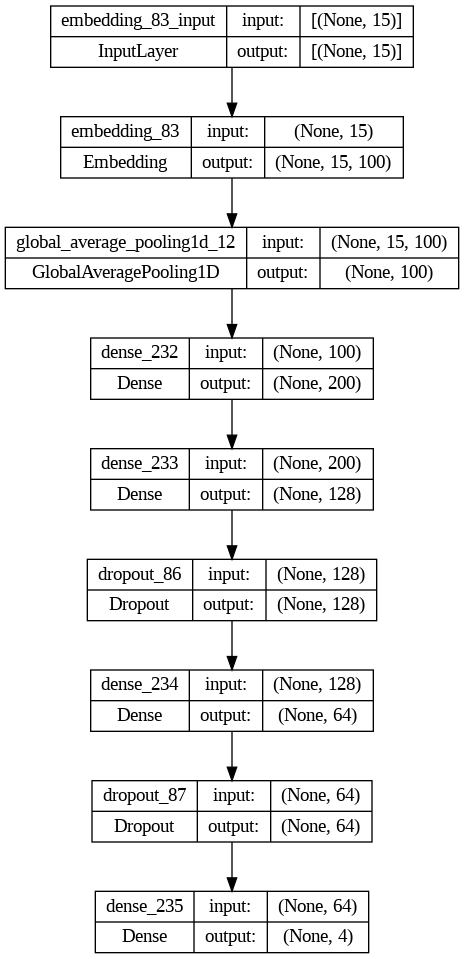

In [ ]:
model = make_deep_average_net()

In [ ]:
# train
history = model.fit(train_x, train_y, batch_size=128, epochs=15, validation_data=(dev_x, dev_y)) #128, 15

Epoch 1/15
51/51 [==============================] - 2s 18ms/step - loss: 1.1875 - accuracy: 0.4877 - val_loss: 1.0930 - val_accuracy: 0.6044
Epoch 2/15
51/51 [==============================] - 1s 14ms/step - loss: 1.0701 - accuracy: 0.5133 - val_loss: 1.0740 - val_accuracy: 0.6044
Epoch 3/15
51/51 [==============================] - 1s 14ms/step - loss: 0.9452 - accuracy: 0.5446 - val_loss: 0.9787 - val_accuracy: 0.6234
Epoch 4/15
51/51 [==============================] - 1s 14ms/step - loss: 0.6959 - accuracy: 0.6587 - val_loss: 0.9965 - val_accuracy: 0.5854
Epoch 5/15
51/51 [==============================] - 1s 14ms/step - loss: 0.5300 - accuracy: 0.7528 - val_loss: 1.1072 - val_accuracy: 0.6392
Epoch 6/15
51/51 [==============================] - 1s 14ms/step - loss: 0.4427 - accuracy: 0.8158 - val_loss: 1.3243 - val_accuracy: 0.6361
Epoch 7/15
51/51 [==============================] - 1s 13ms/step - loss: 0.3686 - accuracy: 0.8737 - val_loss: 1.5649 - val_accuracy: 0.6234
Epoch 8/15
51

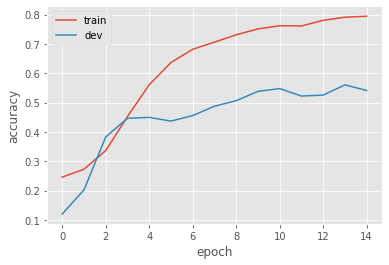

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

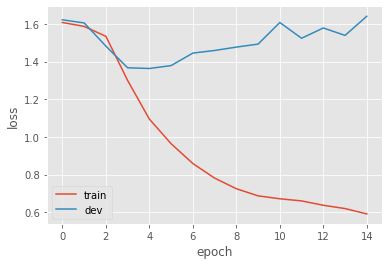

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [ ]:
DAN_aspect_prediction = [np.argmax(x) for x in model.predict(dev_x)]
print(classification_report(dev['label'], DAN_aspect_prediction))

10/10 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.36      0.52      0.42        67
           1       0.40      0.29      0.34        48
           2       0.77      0.74      0.75       191
           3       0.00      0.00      0.00        10

    accuracy                           0.60       316
   macro avg       0.38      0.39      0.38       316
weighted avg       0.60      0.60      0.60       316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<hr style="border: 2px solid #F1EF99;" />

---
## Train the model - CNN

In [ ]:
def make_cnn_model(print_model=True):
    filters = 200 #number of filters in your Convnet
    kernel_size = 3 # a window size of 3 tokens
    hidden_dims = 250 #number of neurons at the normal feedforward NN

    cnn_model = Sequential()
    cnn_model.add(Embedding(input_dim=embedding_matrix.shape[0],
                            input_length=max_len,
                            output_dim=embedding_matrix.shape[1], # comma was missing here
                            weights=[embedding_matrix],
                            mask_zero=True,
                            trainable=True))

    cnn_model.add(Conv1D(filters,
                         kernel_size,
                         input_shape=(max_len, embedding_dim),
                         padding='valid',
                         activation='relu',
                         strides=1,))

    cnn_model.add(BatchNormalization())

    cnn_model.add(GlobalMaxPooling1D())
    #GlobalMaxPooling1D(n) default = 2.
    cnn_model.add(Dense(hidden_dims, activation='relu'))
                        #, kernel_regularizer=regularizers.l2(1e-4), bias_regularizer=regularizers.l2(1e-4)))

    cnn_model.add(Dense(150, activation='relu'))

    cnn_model.add(Dropout(0.4))
    cnn_model.add(Dense(4, activation='softmax'))
    # compile model
    #opp=optimizers.Adam(learning_rate=0.001)
    #cnn_model.compile(optimizer=opp, loss="categorical_crossentropy", metrics=["accuracy"])
    cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
    cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    if print_model:
        cnn_model.summary()
        plot_model(cnn_model, show_shapes=True, to_file='model.png')
        display_png(Image('model.png'))
    return cnn_model

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_85 (Embedding)    (None, 15, 100)           411900    
                                                                 
 conv1d_65 (Conv1D)          (None, 13, 200)           60200     
                                                                 
 batch_normalization_61 (Bat  (None, 13, 200)          800       
 chNormalization)                                                
                                                                 
 global_max_pooling1d_63 (Gl  (None, 200)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_239 (Dense)           (None, 250)               50250     
                                                                 
 dense_240 (Dense)           (None, 150)             

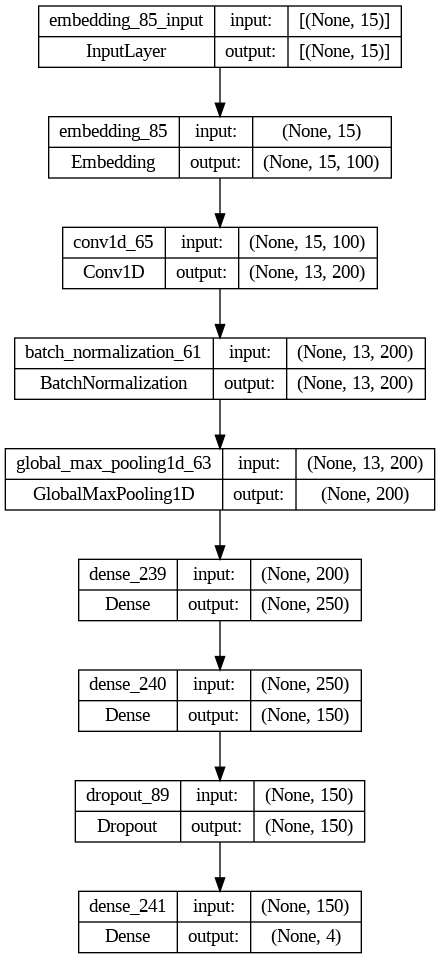

In [ ]:
cnn_model = make_cnn_model()

In [ ]:
cnn_history = cnn_model.fit(train_x, train_y, batch_size=128, epochs=9, validation_data=(dev_x, dev_y))

Epoch 1/9
51/51 [==============================] - 4s 40ms/step - loss: 1.0160 - accuracy: 0.5322 - val_loss: 1.1593 - val_accuracy: 0.6044
Epoch 2/9
51/51 [==============================] - 2s 34ms/step - loss: 0.5395 - accuracy: 0.7927 - val_loss: 1.0486 - val_accuracy: 0.6297
Epoch 3/9
51/51 [==============================] - 2s 35ms/step - loss: 0.2244 - accuracy: 0.9232 - val_loss: 0.9968 - val_accuracy: 0.6139
Epoch 4/9
51/51 [==============================] - 2s 35ms/step - loss: 0.1768 - accuracy: 0.9404 - val_loss: 1.0050 - val_accuracy: 0.6392
Epoch 5/9
51/51 [==============================] - 2s 47ms/step - loss: 0.1266 - accuracy: 0.9561 - val_loss: 0.9487 - val_accuracy: 0.6424
Epoch 6/9
51/51 [==============================] - 3s 58ms/step - loss: 0.1183 - accuracy: 0.9557 - val_loss: 1.0199 - val_accuracy: 0.6297
Epoch 7/9
51/51 [==============================] - 2s 35ms/step - loss: 0.1063 - accuracy: 0.9579 - val_loss: 0.9746 - val_accuracy: 0.6677
Epoch 8/9
51/51 [===

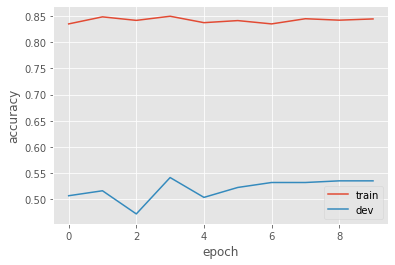

In [ ]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

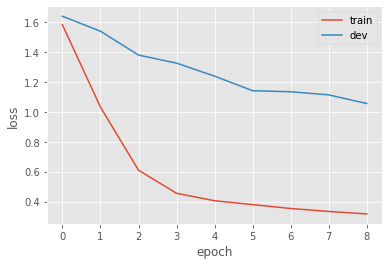

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [ ]:
model.evaluate(dev_x, dev_y)[1]

10/10 [==============================] - 0s 3ms/step - loss: 1.4567 - accuracy: 0.5538


0.5537974834442139

In [ ]:
prediction = [np.argmax(x) for x in cnn_model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

10/10 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.49      0.39      0.43        67
           1       0.50      0.02      0.04        48
           2       0.67      0.92      0.78       191
           3       0.00      0.00      0.00        10

    accuracy                           0.64       316
   macro avg       0.42      0.33      0.31       316
weighted avg       0.59      0.64      0.57       316



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cnn_model.evaluate(dev_x, dev_y)[1]

10/10 [==============================] - 0s 5ms/step - loss: 1.1185 - accuracy: 0.5696


0.5696202516555786

<br>
<hr style="border: 4px solid #B7C9F2;" />
<hr style="border: 2px solid #FB88B4;" />

---

<a id="top"></a>

# Code for Hyperparameter Tuning - CNN

In [ ]:
from keras import optimizers, regularizers
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
              loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
Dense(200, activation='relu',
      kernel_regularizer=regularizers.l2(l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4))

In [ ]:
cnn_model.add(Dropout(0.8))

In [ ]:
cnn_accs = []
for i in range(10):
    model = make_cnn_model(print_model=False)
    model.fit(train_x, train_y, batch_size=256, epochs=10, validation_data=(dev_x, dev_y))
    cnn_accs.append(model.evaluate(dev_x, dev_y)[1])

Epoch 1/10
26/26 [==============================] - 6s 67ms/step - loss: 1.6452 - accuracy: 0.3197 - val_loss: 1.6595 - val_accuracy: 0.1329
Epoch 2/10
26/26 [==============================] - 1s 57ms/step - loss: 1.3169 - accuracy: 0.4771 - val_loss: 1.6674 - val_accuracy: 0.1234
Epoch 3/10
26/26 [==============================] - 2s 59ms/step - loss: 0.9210 - accuracy: 0.6822 - val_loss: 1.6513 - val_accuracy: 0.1930
Epoch 4/10
26/26 [==============================] - 2s 59ms/step - loss: 0.6036 - accuracy: 0.7988 - val_loss: 1.5351 - val_accuracy: 0.3513
Epoch 5/10
26/26 [==============================] - 2s 71ms/step - loss: 0.5311 - accuracy: 0.8199 - val_loss: 1.3904 - val_accuracy: 0.5095
Epoch 6/10
26/26 [==============================] - 3s 101ms/step - loss: 0.4294 - accuracy: 0.8538 - val_loss: 1.3433 - val_accuracy: 0.4778
Epoch 7/10
26/26 [==============================] - 2s 66ms/step - loss: 0.3771 - accuracy: 0.8605 - val_loss: 1.2895 - val_accuracy: 0.5759
Epoch 8/10
2

In [ ]:
cnn_accs_df = pd.DataFrame(cnn_accs, columns=['CNN'])
print(cnn_accs_df.round(4))
cnn_accs_df.describe()

      CNN
0  0.4589
1  0.5633
2  0.5443
3  0.4367
4  0.4335
5  0.5285
6  0.5063
7  0.3544
8  0.5348
9  0.5032


,CNN
count,10.000000
mean,0.486392
std,0.064545
min,0.354430
25%,0.442247
50%,0.504747
75%,0.533228
max,0.563291


In [ ]:
prediction = [np.argmax(x) for x in cnn_model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

10/10 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        92
           1       0.67      0.80      0.73       105
           2       0.74      0.43      0.55        53
           3       0.39      0.33      0.36        33
           4       0.41      0.33      0.37        33

    accuracy                           0.60       316
   macro avg       0.56      0.51      0.53       316
weighted avg       0.60      0.60      0.59       316



<br>
<hr style="border: 4px solid #B7C9F2;" />
<hr style="border: 2px solid #FB88B4;" />

---

<a id="top"></a>

# Code for Hyperparameter Tuning - DAN

In [ ]:
from keras import optimizers, regularizers
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
Dense(200, activation='relu',
      kernel_regularizer=regularizers.l2(l2=1e-4),
      bias_regularizer=regularizers.l2(1e-4))

In [ ]:
model.add(Dropout(0.8))

In [ ]:
dan_accs = []
for i in range(20):
    model = make_deep_average_net(print_model=False)
    model.fit(train_x, train_y, batch_size=128, epochs=10, validation_data=(dev_x, dev_y))
    dan_accs.append(model.evaluate(dev_x, dev_y)[1])

Epoch 1/10
20/20 [==============================] - 2s 32ms/step - loss: 1.5939 - accuracy: 0.3047 - val_loss: 1.5661 - val_accuracy: 0.3149
Epoch 2/10
20/20 [==============================] - 0s 18ms/step - loss: 1.5426 - accuracy: 0.3189 - val_loss: 1.4850 - val_accuracy: 0.3149
Epoch 3/10
20/20 [==============================] - 0s 19ms/step - loss: 1.5162 - accuracy: 0.3439 - val_loss: 1.4678 - val_accuracy: 0.5047
Epoch 4/10
20/20 [==============================] - 0s 18ms/step - loss: 1.4827 - accuracy: 0.3871 - val_loss: 1.4176 - val_accuracy: 0.5301
Epoch 5/10
20/20 [==============================] - 0s 19ms/step - loss: 1.4139 - accuracy: 0.4263 - val_loss: 1.3272 - val_accuracy: 0.5475
Epoch 6/10
20/20 [==============================] - 0s 20ms/step - loss: 1.3186 - accuracy: 0.4952 - val_loss: 1.2032 - val_accuracy: 0.5870
Epoch 7/10
20/20 [==============================] - 0s 19ms/step - loss: 1.1942 - accuracy: 0.5436 - val_loss: 1.0817 - val_accuracy: 0.6440
Epoch 8/10
20

In [ ]:
dan_accs_df = pd.DataFrame(dan_accs, columns=['DAN'])
print(dan_accs_df.round(4))
dan_accs_df.describe()

       DAN
0   0.6661
1   0.6693
2   0.6820
3   0.6820
4   0.6709
5   0.6725
6   0.6835
7   0.6804
8   0.6867
9   0.6709
10  0.6756
11  0.6709
12  0.6646
13  0.6804
14  0.6709
15  0.6899
16  0.6693
17  0.6630
18  0.6614
19  0.6756


,DAN
count,20.000000
mean,0.674288
std,0.008056
min,0.661392
25%,0.669304
50%,0.671677
75%,0.680775
max,0.689873


In [ ]:
prediction = [np.argmax(x) for x in model.predict(dev_x)]
print(classification_report(dev['label'], prediction))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       199
           1       0.83      0.93      0.88       204
           2       0.42      0.69      0.52       102
           3       0.50      0.04      0.08        72
           4       0.00      0.00      0.00        55

    accuracy                           0.68       632
   macro avg       0.49      0.50      0.45       632
weighted avg       0.62      0.68      0.62       632



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.concat([dan_accs_df.describe(), cnn_accs_df.describe()], axis=1)

,DAN,CNN
count,20.000000,20.000000
mean,0.674288,0.631250
std,0.008056,0.062039
min,0.661392,0.507911
25%,0.669304,0.602057
50%,0.671677,0.617880
75%,0.680775,0.662184
max,0.689873,0.738924


# predict & สร้างตารางใหม่

In [ ]:
aspect_map_dict = {0:'food', 1:'anecdotes/miscellaneous', 2:'service', 3:'ambience', 4:'price'}
# Use .replace() to convert the numbers to new values
newdf['aspectCategory'] = newdf['aspectCategory'].replace(aspect_map_dict)

polarity_map_dict = {0:'negative', 1:'neutral', 2:'positive', 3:'conflict'}

newdf['polarity'] = newdf['polarity'].replace(polarity_map_dict)

In [ ]:
# create new dataframe
newdf = pd.DataFrame()

# add columns (เอาผลมารวมกัน)
newdf['id'] = dev['id']
newdf['aspectCategory'] = dev['aspectCategory']  # prediction of aspect
newdf['polarity'] = dev['polarity']  # prediction of polarity
newdf
# export to csv
newdf.to_csv('pred.csv', index=None)

# evaluate "lab4_train.csv" ไม่ต้องเปลี่ยน
!python3 evaluate.py contest1_train.csv pred.csv

,id,aspectCategory,polarity
292,3699,price,positive
1813,503,ambience,positive
3122,1295,service,negative
3134,758,food,neutral
2867,89,price,positive
...,...,...,...
1616,2101,price,negative
2509,2833,ambience,positive
150,2936,anecdotes/miscellaneous,negative
407,1891,food,positive
